# Predicting the Presence of Heart Disease with Logistic Regression 

## Table of contents <a name= "toc"></a>
1. [Introduction](#introduction)
2. [Preprocessing and Feature Engineering](#preprocessing)
    1. [Exploratory Data Analysis](#eda)
    2. [Preprocessing summary](#ppsummary)
3. [Finding Relationships](#relationships)
4. [Logistic Regression](#log)
    1. [Understanding Logistic Regression](#understand)
    2. [Creating the Model](#create)
    3. [Training the Model](#train)
    4. [Testing the Model and Analyzing Results](#test)
5. [Tuning the Model](#tune)
    1. [Analyzing Effects of Tuning](#tune_effects)
6. [Conclusion](#conclusion)

## Introduction <a name= "introduction"></a>

Machine learning to save lives presents the power and potential for change in the world around us. With the Heart Disease data set from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease), we can create a classification model to predict the presence of heart disease and help people get life saving care before it's too late. 

UCI has created a python package to easily pull and interact with the data. Let's start by pulling and preprocessing the data.

In [1]:
from ucimlrepo import fetch_ucirepo 
import pprint
  
# Fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

## Preprocessing and Feature Engineering <a name= "preprocessing"></a>
[Back to Table of Contents](#toc)

The link to the dataset has returned a wealth of information. Let's highlight the most important parts
- We have 303 records for analysis
- There are 13 features to use for classification
- Of the 13 features, they are either Categorical or Integer types
- The target column is "num". 0 = no heart disease where 1-4 = varying levels of heart disease
- There are missing values denoted by NaN in the columns "ca" and "thal". We will look to impute these values later on
- Finally, these column names are abbreviated and specific to cardiology. We can rename these fields for ease of understanding

First, we will transform the target column into binary values rather than multiple class classification. This helps us answer the big question of "is a heart disease present?" rather than the more nuanced question of "is a heart disease present, and if so, what is it?". The doctors can take care of that part. 

In [2]:
# Confirm all present values in target column before processing
print(y.value_counts())

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64


In [3]:
# Adjust all non-zero values to be 1
y = y["num"].apply(lambda x: 0 if x==0 else 1)

# Confirm correct values after transformation
print(y.value_counts())

num
0    164
1    139
Name: count, dtype: int64


Next, let"s rename the columns for legibility. The trade off is that code and results can look clunkier, but it's more important that we understand the data. We will dive into the data of the columns later. 

In [4]:
column_map = {
    "age": "age",
    "sex": "male",
    "cp": "chest_pain",
    "trestbps": "resting_blood_pressure",
    "chol": "cholesterol",
    "fbs": "fasting_blood_sugar",
    "restecg": "rest_ecg",
    "thalach": "max_heart_rate",
    "exang": "exercise_induced_pain",
    "oldpeak": "st_depression",
    "slope": "st_slope",
    "ca": "colored_arteries",
    "thal": "thalassemia"
}

X = X.rename(columns=column_map)

Next, let"s find and address missing values. 

In [5]:
import pandas as pd

# Find records with any missing NaN values
missing_vals_index = (X[X.isna().any(axis=1)]).index

# Combine missing these records with the same in the target column
print(pd.concat([X.iloc[missing_vals_index], y.iloc[missing_vals_index]], axis=1))

     age  male  chest_pain  resting_blood_pressure  cholesterol  \
87    53     0           3                     128          216   
166   52     1           3                     138          223   
192   43     1           4                     132          247   
266   52     1           4                     128          204   
287   58     1           2                     125          220   
302   38     1           3                     138          175   

     fasting_blood_sugar  rest_ecg  max_heart_rate  exercise_induced_pain  \
87                     0         2             115                      0   
166                    0         0             169                      0   
192                    1         2             143                      1   
266                    1         0             156                      1   
287                    0         0             144                      0   
302                    0         0             173                  

Because there is a small amount of data in this dataset (303 records) and few rows (6) with only one missing value each, we will use imputation. Imputation fills missing values with the mode or mean value from that field. 

Imputation preserves valuable data from the rest of the record without introducing a significant risk of confounding the data.

Because we have data for case and non case values, let's impute the missing values with the `ca` mean (integer feature) and `thal` mode (categorical feature) for the respective section of the dataset with the same target value.

In [6]:
# Isolate rows for case values
case_index = y[y==1].index
print("case instances")
print(f"Mean colored_arteries: {round(X.loc[case_index,:]['colored_arteries'].mean(),0)}")
print(f"Mode thalassemia: {X.loc[case_index,:]['thalassemia'].mode()[0]}")

# Isolate rows for non case values
non_case_index = y[y==0].index
print("non-case instances")
print(f"Mean colored_arteries: {round(X.loc[non_case_index,:]['colored_arteries'].mean(),0)}")
print(f"Mode thalassemia: {X.loc[non_case_index,:]['thalassemia'].mode()[0]}")

case instances
Mean colored_arteries: 1.0
Mode thalassemia: 7.0
non-case instances
Mean colored_arteries: 0.0
Mode thalassemia: 3.0


Because there are only a few values to replace and we do not need to repeat this, we will manually update these values. If that were not the case, we would create a function to update these values dependent on the column and case value. 

In [7]:
X.loc[87,"thalassemia"] = 3.0
X.loc[166, "colored_arteries"] = 0.0
X.loc[192, "colored_arteries"] = 1.0
X.loc[266, "thalassemia"] = 7.0
X.loc[287, "colored_arteries"] = 0.0
X.loc[302, "colored_arteries"] = 0.0

### Exploratory Data Analysis <a name= "eda"></a>

Now that the data is cleaned, we will organize the variables into categorical and integer features and visualize the data for further analysis.

Matplotlib is building the font cache; this may take a moment.


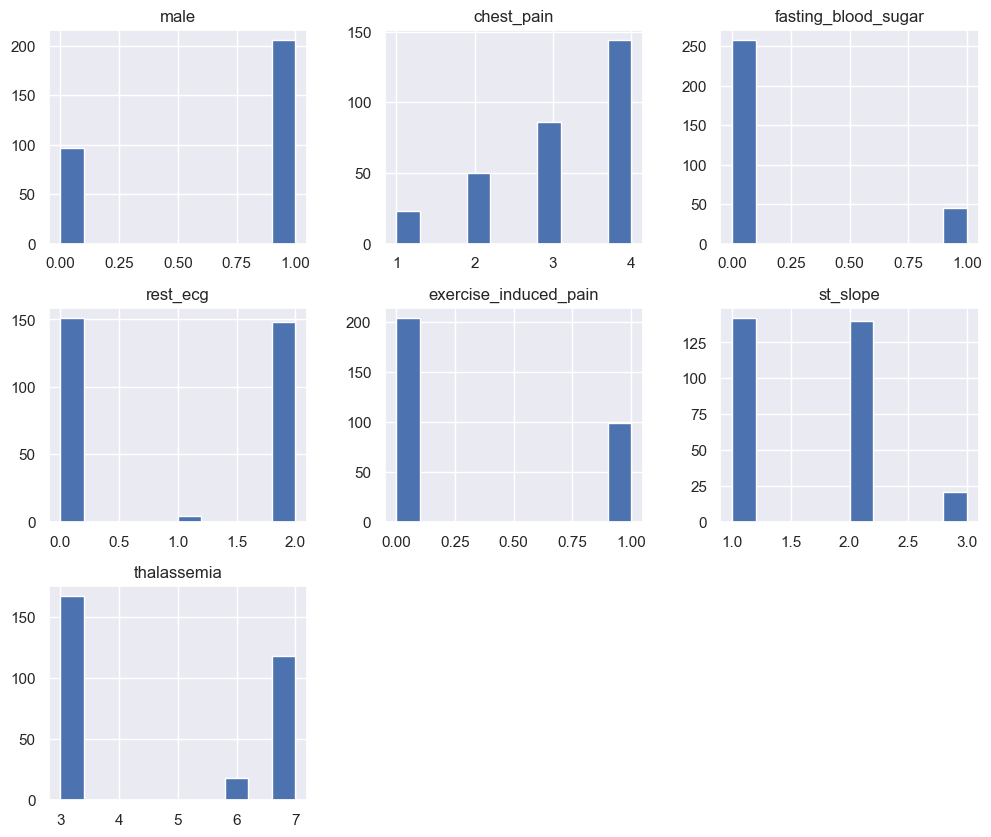

In [8]:
# import visualization library and set style
import matplotlib
import seaborn as sns
sns.set_theme()
sns.set_color_codes("muted")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Isolate categorical and integer features
cat_feats = ["male", "chest_pain", "fasting_blood_sugar", "rest_ecg", "exercise_induced_pain", "st_slope", "thalassemia"]

# Create histograms of categorical features
X[cat_feats].hist(figsize=(12,10))
plt.show()

Notes on the categorical variables:
* `male`: More than twice as many men are present in this dataset than women, which can bias the model towards better performance with males
    * **0**: female
    * **1**: male
* `chest_pain`: represents the type of chest pain felt by the patient. Most commonly asymptomatic
    * **1**: typical angina (typical heart pain)
    * **2**: atypical angina (atypical heart pain)
    * **3**: non-anginal pain (chest pain unrelated to heart disease)
    * **4**: asymptomatic (no chest pain)
* `fasting_blood_sugar`: represents whether the patient's fasting blood sugar >120mg/dl. According to [Mount Sinai Hospital](https://mountsinai.org/health-library/tests/blood-sugar-test-blood#:~:text=A%20level%20of%20100%20to,usually%20means%20you%20have%20diabetes.), this level of fasting blood sugar indicates presence of prediabetes or diabetes, which could correlate with presence of heart disesease
    * **0**: false
    * **1**: true
* `rest_ecg`: represents ecg results at rest
    * **0**: normal
    * **1**: 1 is common and [not necessarily indicative of an issue](https://www.uptodate.com/contents/ecg-tutorial-st-and-t-wave-changes#:~:text=ST%2D%20and%20T%2Dwave%20changes%20may%20represent%20cardiac%20pathology%20or,similar%20findings%20on%20prior%20electrocardiograms.&text=Nonspecific%20ST%2DT%2Dwave%20changes%20are%20very%20common%20and%20may,any%20lead%20of%20the%20electrocardiogram.)
    * **2**: probable to definite sign of thickening heart muscles, making it [harder to pump blood](https://www.mayoclinic.org/diseases-conditions/left-ventricular-hypertrophy/symptoms-causes/syc-20374314) and increasing the risk of heart disease
* `exercise_induced_pain`: signifies if the chest pain was brought on by exercise, which looks to be about 30% of the records and is likely higher for instances when heart disease is present
    * **0**: false
    * **1**: true
* `st_slope`: this represents shape  an ST slope and can be an important marker in [reduced blood flow](https://www.ajconline.org/article/S0002-9149(01)02052-5/abstract#:~:text=ST%20slope%20is%20a%20sensitive,even%20better%20than%20ST%20depression.) to the heart
    * **0**: upsloping
    * **1**: flat
    * **2**: downsloping
* `thalassemia`: While not defined in the data dictionary, `thatl` likel refers to a blood disorder called Thalassemia which limits how much oxygen can be carried in the blood.
    * **3**: normal
    * **6**: fixed defect
    * **7**: reversable defect


Next, we will OHE (one hot encode) the categorical variables with more than two classes because the logistic regression model will assume a scalar relationship between the values. For example, a value of 3 in the `slope` variable is not three times more than a value of `1`, but the logistic model will treat it as such. 

With OHE, it is best practice to drop one of the columns to avoid the problem of multicollinearity. This is when two or more independent variables are highly correlated with each other. As a result, the causal relationships between the indepent variables and the target variable can be unclear and the model will overfit. 

Logistic regression assumes independence between independent variables. If we waited to drop variables until after testing for relationships between them and the target variable, it could result in dropping columns that do not affect the independence between the remaining categories. 

In [9]:
# Create OHE values for the necessary categorical features
one_hot_cols = ["chest_pain", "rest_ecg","st_slope","thalassemia"]

X_encoded = X.copy()

# Replace orginal columns with OHE columns
for col in one_hot_cols:
    # Create one hot columns
    encoded = pd.get_dummies(X_encoded[col], prefix= col, drop_first= True)
    
    # Update df and categorical features list
    X_encoded = X_encoded.drop(columns= col)
    cat_feats.remove(col)
    
    X_encoded = pd.concat([X_encoded, encoded], axis= 1)
    for new_col in encoded.columns:
        cat_feats.append(new_col)

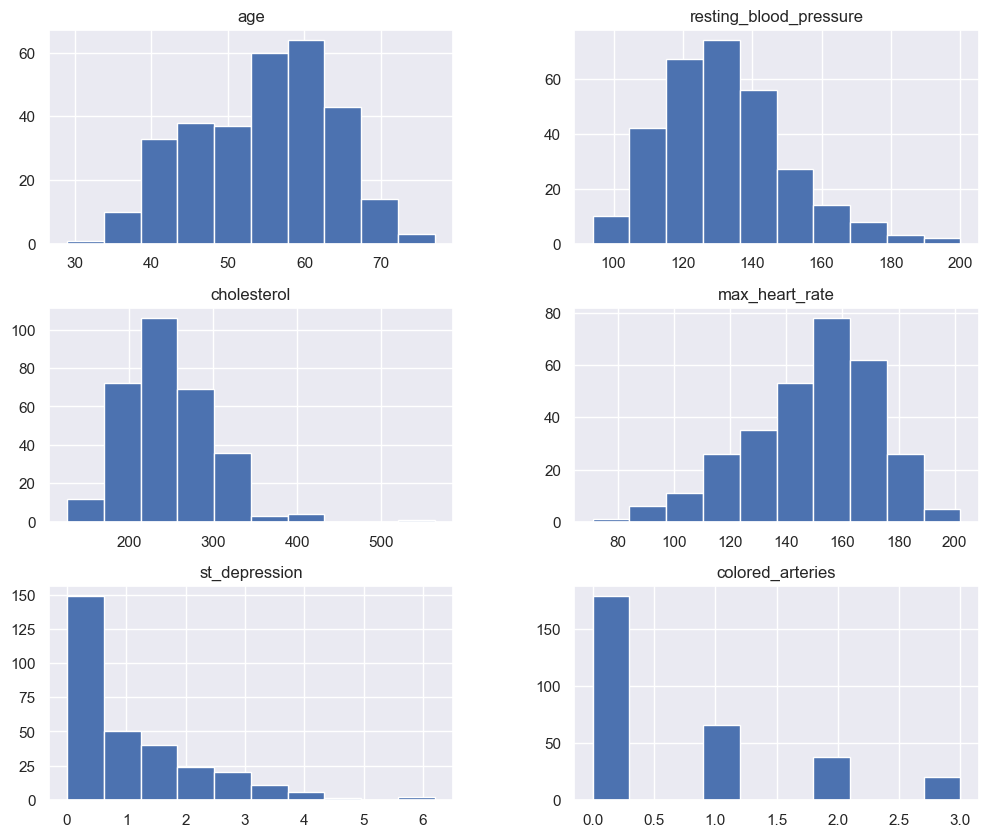

In [10]:
int_feats = ["age", "resting_blood_pressure", "cholesterol", "max_heart_rate", "st_depression", "colored_arteries"]

# Create histograms of integer features
plots = X_encoded[int_feats].hist(figsize=(12,10))
plt.show()

Notes on the integer variables

- `age`: The distribution is negatively skewed, showing that there are more instances of older people present in this dataset
- `resting_blood_pressure`: resting blood pressure, of which a healthy range is different by sex and age
- `cholesterol`: serum cholesterol
- `max_heart_rate`: maximum heart rate achieved
- `st_depression`: "ST depression induced by exercise relative to rest". ST depression is a finding on an ECG which measures the rhythm and electrical activity in the heart.  The presence of an ST depression [can indicate potentially life threatening disease](https://www.medicalnewstoday.com/articles/st-depression-on-ecg#:~:text=An%20ECG%20is%20a%20test,reviewed%20on%20April%2025%2C%202024)
- `colored_arteries`: represents the number of major vessels colored by flourosopy and can identify [narrowing or blockages in artieries](https://my.clevelandclinic.org/health/diagnostics/21992-fluoroscopy#test-details)

Because this dataset has variables with different scales, something logistic regression is sensitive to, we will use standard scaling to avoid an overemphasis on variables with larger scales and vice versa. Standard scaling transforms data to have normal distribution with the mean at 0 and values measured in standard deviations (SD) away from the mean. 

In [11]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Create copy to preserve orginal data
X_scaled = X_encoded.copy()

# Fit and transform integer features
scaled_features = scaler.fit_transform(X[int_feats])

# Update X with scaled features
X_scaled[int_feats] = scaled_features

### Preprocessing summary <a name= "ppsummary"></a>

We did multiple things to prepare the dataset for analysis. We simplified the target variable into "does the patient have heart disease or not?", we made the column names easier to understand, we OHE categorical features and standard scaled numerical features so that they're appropriate for logistic regression.

## Finding relationships <a name= "relationships"></a>
[Back to Table of Contents](#toc)

Now that the features have been prepared, we are ready to look for relationships between them and the target variable. 

We will start with using a chi square test on the categorical features. Chi square tests operate on the assumption that there is no significant difference between the proportions of observed instances amongst the tested categories. If there is a significant difference, this points to a relationship that can be useful for building our logistic regression model. 

In [12]:
from scipy.stats import chi2_contingency

# Create function to run chi square test
def chi_square(cat_col):
    # Create a contingency table
    contingency_table = pd.crosstab(cat_col, y)

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # Standard 5% significance level
    return round(chi2,2), p, significant

# Run the chi_square function for each of the categorical features
chi_square_results = {}
for col in cat_feats:
    chi_square_results[col] = chi_square(X_scaled[col])
pprint.pp(chi_square_results)

{'male': (np.float64(22.04), np.float64(2.666712348180942e-06), np.True_),
 'fasting_blood_sugar': (np.float64(0.08),
                         np.float64(0.7812734067063785),
                         np.False_),
 'exercise_induced_pain': (np.float64(54.69),
                           np.float64(1.413788096718085e-13),
                           np.True_),
 'chest_pain_2': (np.float64(17.42),
                  np.float64(2.999461848863365e-05),
                  np.True_),
 'chest_pain_3': (np.float64(28.71),
                  np.float64(8.425565836925393e-08),
                  np.True_),
 'chest_pain_4': (np.float64(78.76),
                  np.float64(7.023529768902272e-19),
                  np.True_),
 'rest_ecg_1': (np.float64(0.45), np.float64(0.5017489946446447), np.False_),
 'rest_ecg_2': (np.float64(7.16), np.float64(0.007434268855662301), np.True_),
 'st_slope_2': (np.float64(36.92), np.float64(1.230960081661359e-09), np.True_),
 'st_slope_3': (np.float64(0.72), np.float64(0.

Wow! The results of the chi square tests show that most of the features have a significant relationship with the presence of heart disease. 

The chi square value measures the diference between the observed and expected frequencies while the p-value represents the percentage chance that the observed relationship is due to chance rather than a connection between the variables. A higher chi square value and a lower p value represent stronger relationships.

We will remove columns that did not have a significant p value, as they are more likely to weaken the predictive model. 

In [13]:
for k in chi_square_results:
    if chi_square_results[k][2] == False:
        X_scaled = X_scaled.drop(columns=k)
        cat_feats.remove(k)

Now, we can move on to finding relationships between the integer variables and the target variable. With some online research, I found multiple tests to run so we can create a stronger understanding of the relationships between the variables.

Each test tells us something different:

* Point-Biserial Correlation shows the linear relationship strength between the independent and target variable (-1 to 1)
* Mann-Whitney U test compares distributions and shows whether the distributions differ significantly
* Cohen"s d measures effect size between two groups by expressing the difference between their means in standard deviation units
* Logistic Regression Single Feature Analysis shows the predictive power of the indepdent variable (AUC-ROC)

In [14]:
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from statsmodels.stats.multitest import multipletests
from rich.console import Console
console = Console()
from rich.table import Table

def analyze_numeric_binary_relationships(
    df, 
    numeric_columns, 
    target_column,
    alpha=0.05,
    multiple_testing_method="fdr_bh"
):
    """
    Comprehensive analysis of relationships between numeric features and binary target.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing features and target
    numeric_columns : list
        List of numeric column names to analyze
    target_column : str
        Name of binary target column
    alpha : float, default=0.05
        Significance level for hypothesis tests
    multiple_testing_method : str, default="fdr_bh"
        Multiple testing correction method
        
    Returns:
    --------
    dict containing:
        - summary_df: DataFrame with all test results
        - figures: Dictionary of generated plots
        - significant_features: List of significant features
    """
    results = []
    figures = {}
    
    for col in numeric_columns:
        # 1. Point-Biserial Correlation
        correlation, pb_pvalue = stats.pointbiserialr(
            df[col],
            df[target_column]
        )
        
        # 2. Mann-Whitney U Test
        mw_statistic, mw_pvalue = stats.mannwhitneyu(
            df[df[target_column] == 0][col],
            df[df[target_column] == 1][col],
            alternative="two-sided"
        )
        
        # 3. Effect Size (Cohen"s d)
        group0 = df[df[target_column] == 0][col]
        group1 = df[df[target_column] == 1][col]
        cohens_d = (group1.mean() - group0.mean()) / np.sqrt(
            ((group1.std() ** 2 + group0.std() ** 2) / 2)
        )
        
        # 4. Logistic Regression Single Feature
        model = LogisticRegression(random_state=42)
        model.fit(df[[col]], df[target_column])
        auc = roc_auc_score(
            df[target_column], 
            model.predict_proba(df[[col]])[:, 1]
        )
        
        
        # Store all results
        results.append({
            "feature": col,
            "correlation": correlation,
            "pb_pvalue": pb_pvalue,
            "mw_pvalue": mw_pvalue,
            "cohens_d": cohens_d,
            "auc_roc": auc,
            "mean_target_0": group0.mean(),
            "mean_target_1": group1.mean(),
            "std_target_0": group0.std(),
            "std_target_1": group1.std()
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results)
    
    # Apply multiple testing correction
    _, pb_corrected_pvalues, _, _ = multipletests(
        summary_df["pb_pvalue"], 
        alpha=alpha, 
        method=multiple_testing_method
    )
    _, mw_corrected_pvalues, _, _ = multipletests(
        summary_df["mw_pvalue"], 
        alpha=alpha, 
        method=multiple_testing_method
    )
    
    summary_df["pb_corrected_pvalue"] = pb_corrected_pvalues
    summary_df["mw_corrected_pvalue"] = mw_corrected_pvalues
    
    # Add interpretation columns
    summary_df["correlation_strength"] = summary_df["correlation"].apply(
        lambda x: "Strong" if abs(x) > 0.5 
        else "Moderate" if abs(x) > 0.3 
        else "Weak"
    )
    
    summary_df["effect_size_interpretation"] = summary_df["cohens_d"].apply(
        lambda x: "Large" if abs(x) > 0.8 
        else "Medium" if abs(x) > 0.5 
        else "Small" if abs(x) > 0.2 
        else "Negligible"
    )
    
    # Identify significant features
    significant_features = summary_df[
        (summary_df["pb_corrected_pvalue"] < alpha) | 
        (summary_df["mw_corrected_pvalue"] < alpha)
    ]["feature"].tolist()
    
    return {
        "summary_df": summary_df,
        "significant_features": significant_features
    }

def print_analysis_summary(analysis_results):
    """
    Print summary of the analysis results.
    """
    summary_df = analysis_results["summary_df"]
    significant = analysis_results["significant_features"]
    
    print(f"Number of significant features: {len(significant)}\n")
    
    if significant:
        summary_table = Table(title="Significant Features Summary")

        summary_table.add_column("Feature", justify="left", no_wrap=True)
        summary_table.add_column("Correlation")
        summary_table.add_column("Effect Size")
        summary_table.add_column("AUC-ROC")
        summary_table.add_column("Mean Difference")
        
        for feature in significant:
            row = summary_df[summary_df["feature"] == feature].iloc[0]
            summary_table.add_row(f"{feature}", f"{row['correlation']:.3f} ({row['correlation_strength']})", f"{row['cohens_d']:.3f} ({row['effect_size_interpretation']})",f"{row['auc_roc']:.3f}",f"{row['mean_target_1'] - row['mean_target_0']:.3f}")
            # print(f"\n{feature}:")
            # print(f"- Correlation: {row["correlation"]:.3f} ({row["correlation_strength"]})")
            # print(f"- Effect Size: {row["cohens_d"]:.3f} ({row["effect_size_interpretation"]})")
            # print(f"- AUC-ROC: {row["auc_roc"]:.3f}")
            # print(f"- Mean difference: {row["mean_target_1"] - row["mean_target_0"]:.3f}")
    
    return console.print(summary_table)

analysis_results = analyze_numeric_binary_relationships(
    pd.concat([X_scaled, y], axis=1), 
    int_feats, 
    "num")
print_analysis_summary(analysis_results)

Number of significant features: 6



                                 Significant Features Summary                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Feature                ┃ Correlation       ┃ Effect Size        ┃ AUC-ROC ┃ Mean Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ age                    │ 0.223 (Weak)      │ 0.461 (Small)      │ 0.637   │ 0.448           │
│ resting_blood_pressure │ 0.151 (Weak)      │ 0.303 (Small)      │ 0.574   │ 0.303           │
│ cholesterol            │ 0.085 (Weak)      │ 0.172 (Negligible) │ 0.570   │ 0.171           │
│ max_heart_rate         │ -0.417 (Moderate) │ -0.912 (Large)     │ 0.745   │ -0.837          │
│ st_depression          │ 0.425 (Moderate)  │ 0.919 (Large)      │ 0.735   │ 0.852           │
│ colored_arteries       │ 0.464 (Moderate)  │ 1.029 (Large)      │ 0.753   │ 0.932           │
└────────────────────────┴───────────────────┴────────────────────┴─────────┴─────────────────┘

While `age`, `resting_blood_pressure`, and `cholesterol` have significant relationships to the presence of heart disease, the strength of that relationship and the effect they have on the presence of heart disease is small. Of these three, `age` appears to be the strongest predictor of heart disease. 

Compare that to `max_heart_rate`, `st_depression`, and `colored_arteries`, which all have much stronger relationships to the presence of heart disease. 

For the logistic regression model, we will use all of these variables. However, we can use this information to inform patients that their likelihood of developing heart disease is more likely to be affected by things they can control like increasing their max heart rate with exercise and keeping their arteries clear by eating healthy.

## Logistic Regression <a name= "log"></a>
[Back to table of contents](#toc)

### Understanding Logistic Regression <a name= "understand"></a>
Logistic regression is a helpful model for this situation because it allows us to input multiple variables and result in a yes/no (or binary) prediciton. 

To do this, we transform the input variables into probability between 0-1 using the "logistic" or "sigmoid" function. 

$$P(EY) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1)}}$$

Where $P(EY)$ is the probability event Y occurs.

This results in the curve below

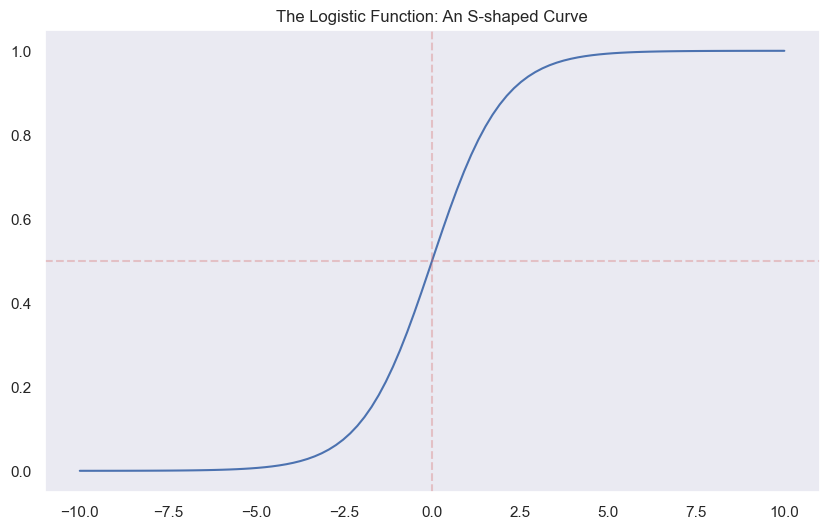

In [15]:
# Create example data
ex_x = np.linspace(-10, 10, 100)
ex_y = 1 / (1 + np.exp(-ex_x))

# Plot logistic function
plt.figure(figsize=(10, 6))
plt.plot(ex_x, ex_y)
plt.title('The Logistic Function: An S-shaped Curve')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.grid(False)
plt.show()

The S-Shaped curve fits binary classification for multiple reasons
 * The output is bounded between 0 and 1, no matter how extreme the inputs. This ensures that we always get a valid probability
 * The curve changes gradually, then very quickly. This reflects how things can shift very quickly in the nexus of situation, but as we near an outcome, probabilities change less

To do this, logistic regression transforms input data into predictions with three elements:
 1. Input features (the data)
 2. Weights (what the model learns)
 3. The logistic function (the S-curve transformer)
 
First, the features are combined linearly

$$z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

Then, this is transformed into a probability using the sigmoid function

$$P(EY) = \frac{1}{1 + e^{-z}}$$

Now that we understand how the function works, we can build the model!

### Creating the Model <a name= "create"></a>

Now that we have identified which variables have a significant relationship with the presence of heart disease, we can set to work on creating our logistic regression model that will allow us to better predict whether a patient has a heart disease. To ensure the model accurately reflects the data set, we will split train and test data to contain proportions reflective of the case vs non case values.

After we transformed our data, we saw that there are 164 non-case:139 case values (54%:46%). To maintain this ratio, we will use the stratify parameter in train_test_split.

In [16]:
from sklearn.model_selection import train_test_split

# Split data with standard 25% test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=24, stratify=y)

# Ensure that both test and train sets both use cases
print("y_train class balance:")
print(round(y_train.value_counts(normalize=True)*100,2))
print("y_test class balance:")
print(round(y_test.value_counts(normalize=True)*100,2))

y_train class balance:
num
0    54.19
1    45.81
Name: proportion, dtype: float64
y_test class balance:
num
0    53.95
1    46.05
Name: proportion, dtype: float64


### Training the model <a name= "train"></a>

Now that we have confirmed the splits have similar class balances to the whole dataset, we can move on to creating and training the model. 

In [17]:
# Instantiate Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

log_model = LogisticRegression(random_state=24)

In [18]:
# Define function to list features and their coeffecients
def list_coef(model):
    n_feats = model.n_features_in_
    split_feats = np.split(model.feature_names_in_, n_feats)
    split_coef = np.split(model.coef_[0], n_feats)
    coef_dict = {}
    for k, v in zip(split_feats, split_coef):
        coef_dict[k[0]] = round(v[0], 2)
    return coef_dict


# Define function to run and score model
def perform_logistic_regression(model, X, y, train= True):
    
    # Fit model for training, otherwise run as is with test data
    if train == True:
        model.fit(X, y)
    
    # Assign metrics
    intercept = round(np.exp(model.intercept_)[0],4)
    coef = list_coef(model)
    predictions = model.predict(X)
    accuracy = round(accuracy_score(y, predictions)*100,0)
    
    true_positive = sum((y == 1) & (predictions == 1))
    true_negative = sum((y == 0) & (predictions == 0))
    false_positive = sum((y == 0) & (predictions == 1))
    false_negative = sum((y == 1) & (predictions == 0))
    
    sensitivity = round(true_positive / (true_positive + false_negative)*100, 0)
    specificity = round(true_negative / (true_negative + false_positive)*100, 0)
    positive_predictive_value = round(true_positive / (true_positive + false_positive)*100, 0)
    negative_predictive_value = round(true_negative / (true_negative + false_negative)*100, 0)
    false_positive_rate = round(false_positive / (false_positive + true_negative)*100, 0)
    false_negative_rate = round(false_negative / (false_negative + true_positive)*100, 0)
    
    print(f"{y.shape[0]} records analyzed")
    
    if train == True:
        # Prints only on 'train' since the coefficients do not change when performing 'test'
        results_table = Table(title="Model Results")
        results_table.add_column("Metric", justify="left", no_wrap=True)
        results_table.add_column("Result")
        results_table.add_row("Intercept", f"{intercept}")
        for co in coef:
            results_table.add_row(f"Coef: {co}", f"{coef[co]}")
        console.print(results_table)
    
    # Organized printing for metrics that matter in 'train' and 'test'
    scores_table = Table(title="Model Scores")

    scores_table.add_column("Metric", justify="left", no_wrap=True)
    scores_table.add_column("Result")

    scores_table.add_row("Accuracy", f"{accuracy}")
    scores_table.add_row("Sensitivity", f"{sensitivity}")
    scores_table.add_row("Specificity", f"{specificity}")
    scores_table.add_row("Positive Predictive Value", f"{positive_predictive_value}")
    scores_table.add_row("Negative Predictive Value", f"{negative_predictive_value}")
    scores_table.add_row("False Positive Rate", f"{false_positive_rate}")
    scores_table.add_row("False Negative Rate", f"{false_negative_rate}")
    
    
    console.print(scores_table)
    
    return None

perform_logistic_regression(log_model, X_train, y_train, train= True)

227 records analyzed


              Model Results              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                       ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Intercept                    │ 0.0841 │
│ Coef: age                    │ -0.18  │
│ Coef: male                   │ 1.07   │
│ Coef: resting_blood_pressure │ 0.34   │
│ Coef: cholesterol            │ 0.28   │
│ Coef: max_heart_rate         │ -0.55  │
│ Coef: exercise_induced_pain  │ 0.76   │
│ Coef: st_depression          │ 0.2    │
│ Coef: colored_arteries       │ 1.1    │
│ Coef: chest_pain_2           │ 0.53   │
│ Coef: chest_pain_3           │ -0.53  │
│ Coef: chest_pain_4           │ 1.33   │
│ Coef: rest_ecg_2             │ 0.17   │
│ Coef: st_slope_2             │ 0.7    │
│ Coef: thalassemia_7.0        │ 1.22   │
└──────────────────────────────┴────────┘

             Model Scores             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                    ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy                  │ 85.0   │
│ Sensitivity               │ 81.0   │
│ Specificity               │ 89.0   │
│ Positive Predictive Value │ 87.0   │
│ Negative Predictive Value │ 85.0   │
│ False Positive Rate       │ 11.0   │
│ False Negative Rate       │ 19.0   │
└───────────────────────────┴────────┘

Let's review the metrics above. 

#### Intercept
This measures the odds of an event ocurring versus not when all coefficients are 0. 

Intercepts above one signify the event is more likely to happen and the vice versa. Because the intercept is just above 1, it means that the odds of heart disease being present is slightly higher than not. This doesn't mean that everyone is more likely to have heart disease, just in relation to these coefficients and this dataset. 

#### Coefficients and Odds Ratios
Coef: In a logistic regression, the odds ratio represents how the outcome changes with a change in the predictor. We can isolate the coefficient (or slope) by subtracting two equations: one where $X = 0$, and one where $X = 1$, as shown below:

$$log(\frac{EY}{1-EY}) = log(O_0) = \beta_0$$

$$log(\frac{EY}{1-EY}) = log(O_1) = \beta_0 + \beta_1$$

where $O_0$ represents the odds when $X = 0$ and $O_1$ represents the odds when $X = 1$. Subtracting the two returns:

$$log(O_1)- log(O_0) = \beta_1$$
$$=> log(\frac{O_1}{O_0}) = \beta_1$$

Resulting with the coefficient being represented by the **log odds ratio**. We can then express the odds ratio in terms of a function of the slope

$$(\frac{O_1}{O_0})=e^{\beta_1}$$

If the odds ratio is greater than 1, it implies that the odds the event occurring are greater than the odds of the event not occurring. This translates into a higher coefficient. 

We can then calculate how these affect the The five features with the highest impact are `chest_pain_4`, `thalassemia_7.0`, `colored_arteries`, `male`, and `exercise_induced_pain`. 

- `chest_pain_4`: $e^{1.33} = 3.78$ >> Having asymptomatic angina multiplies odds by 3.78 (increases by 278%)
- `thalassemia_7`: $e^{1.21} = 3.35$ >> Having "reverseable defect" thalassemia multiplies odds by 3.35 (increases by 235%)
- `colored_arteries`: $e^{1.09} = 2.97$ >> One SD (Standard Deviation) increase in colored arteries multiplies odds by 2.97 (increases by 197%)
- `male`: $e^{1.07} = 2.92$ >> Being male multiplies odds by 2.92 (increases by 192%)
- `exercise_induced_pain`: $e^{0.76} = 2.14$ >> Having exercise-induced pain multiplies odds by 2.14 (increases by 114%)

#### Accuracy
Accuracy measures the overall correct predictions of the model. This model accurately predicted the presence of heart disease 85% of the time.

#### Sensitivity and specificity
Sensitivity and specificity measure how well the model classifies case and non-case values respectively. This model correctly identified 81% of positive cases and 89% of negative cases.

#### Predictive Values
Positive Predictive and Negative Predictive Values (PPV, NPV) measure the percentage of postive and negative predictions that were accurate. When the model predicted a postive case vs a negative case, it was right 87% of the time vs 85% of the time respectively. 

#### False Rates
False Positive and False Negative Rates (FPR, FNR) measure the likelihood that a positive or negative classification is inaccurate. With a false postive Given the severity of heart disease we would rather have a higher FPR (11%) than FNR (19%), but aiming for that higher rate comes with the risk of overfitting. 

Overall, this model appears to be accurate and suggests that it will work well with new data instead of under or overfitting.

### Testing the Model and Analyzing Results <a name= "test"></a>

Now that we have analyzed the results and are confident with the accuracy of the model, let"s run it on the test dataset. 

In [19]:
perform_logistic_regression(log_model, X_test, y_test, train= False)

76 records analyzed


             Model Scores             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                    ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy                  │ 89.0   │
│ Sensitivity               │ 86.0   │
│ Specificity               │ 93.0   │
│ Positive Predictive Value │ 91.0   │
│ Negative Predictive Value │ 88.0   │
│ False Positive Rate       │ 7.0    │
│ False Negative Rate       │ 14.0   │
└───────────────────────────┴────────┘

The model performed well on the test data set, with scores increasing across the board. But can go further. With hyperparameter tuning, we can hone in to the best model settings for improved performance.

## Tuning the Model
[Back to table of contents](#toc)

To find the best version of the model, we will use GridSearchCV for hyperparameter tuning. GridSearchCV tries many different combinations of a model to find the settings that return the best results so we can create the most accurate model. Lets discuss the parameters we will be tuning.

- penalty: L1 (Lasso), L2 (Ridge)
    - Lasso: "The penalty is the sum of the absolute values of the parameters. This can lead to a sparse model where some parameter values are exactly zero, effectively removing those features from the model."
    - Ridge: "The penalty is the sum of the squares of the parameters. This evenly distributes the penalty among all parameters, shrinking them towards zero but not exactly zeroing any."
- C: The inverse of regularization strength. Regularization modifies the loss function such that it encourages the model to keep coefficients small and prevent overfitting. A higher C value results in less regularization and vice versa. The optimal C value will ensure we neither underfit or overfit the data. 
- fit_intercept: Specifies if a constant (a.k.a. bias or intercept) should be added the decision function. No intercept would reduce bias in the model.
- solver: Algorithm used in the optimization problem

This [source](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning#:~:text=The%20general%20form%20of%20the,keeping%20the%20model%20parameters%20small.) was helpful for learning more about these parameters.

In [20]:
from sklearn.model_selection import GridSearchCV

# List parameters to try during Grid Search Cross Validation
parameters = {"penalty":["l1","l2"], "C":np.logspace(-3,3,7), "fit_intercept":[True, False], "solver":["newton-cg", "lbfgs", "liblinear"]}

# Apply to log_model and find best paramete values
log_model_cv = GridSearchCV(log_model, param_grid=parameters, cv=10)
log_model_cv.fit(X_train, y_train)

print(f"Best parameters: {log_model_cv.best_params_}")
print(f"Accuracy: {round(log_model_cv.best_score_,2)}")

Best parameters: {'C': np.float64(0.1), 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.82


Now that we have tuned parameter combinations, we will create, train, and test the model.

In [21]:
# Create a new logistic regression model with the best parameters
tuned_log = LogisticRegression(C= 0.1, fit_intercept= True, penalty= "l2", solver= "newton-cg", 
                              random_state=24)

perform_logistic_regression(tuned_log, X_train, y_train, train= True)

227 records analyzed


              Model Results              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                       ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Intercept                    │ 0.2888 │
│ Coef: age                    │ -0.07  │
│ Coef: male                   │ 0.47   │
│ Coef: resting_blood_pressure │ 0.2    │
│ Coef: cholesterol            │ 0.15   │
│ Coef: max_heart_rate         │ -0.45  │
│ Coef: exercise_induced_pain  │ 0.46   │
│ Coef: st_depression          │ 0.25   │
│ Coef: colored_arteries       │ 0.69   │
│ Coef: chest_pain_2           │ 0.01   │
│ Coef: chest_pain_3           │ -0.42  │
│ Coef: chest_pain_4           │ 0.65   │
│ Coef: rest_ecg_2             │ 0.08   │
│ Coef: st_slope_2             │ 0.33   │
│ Coef: thalassemia_7.0        │ 0.68   │
└──────────────────────────────┴────────┘

             Model Scores             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                    ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy                  │ 85.0   │
│ Sensitivity               │ 76.0   │
│ Specificity               │ 92.0   │
│ Positive Predictive Value │ 89.0   │
│ Negative Predictive Value │ 82.0   │
│ False Positive Rate       │ 8.0    │
│ False Negative Rate       │ 24.0   │
└───────────────────────────┴────────┘

### Analyzing Effects of Tuning <a name= "tune_effects"></a>

The same five features have the highest impact as in the untuned model, but the lower C value (higher regularization) has resulted in smaller coeffeficients to avoid overfitting. Let's see how tuning the model has changed the size of the coefficients.

In [22]:
# Transform dictionaries of coefficient values into dataframes to combine
untuned_coef= pd.DataFrame.from_dict(list_coef(log_model), orient= "index", columns= ["untuned"])
tuned_coef= pd.DataFrame.from_dict(list_coef(tuned_log), orient= "index", columns= ["tuned"])

# Create a df of coefficients to show change with tuning
coef_df = pd.concat([untuned_coef, tuned_coef], axis= 1)
coef_df["delta"] = round((coef_df["tuned"] - coef_df["untuned"])/coef_df["untuned"]*100,2)

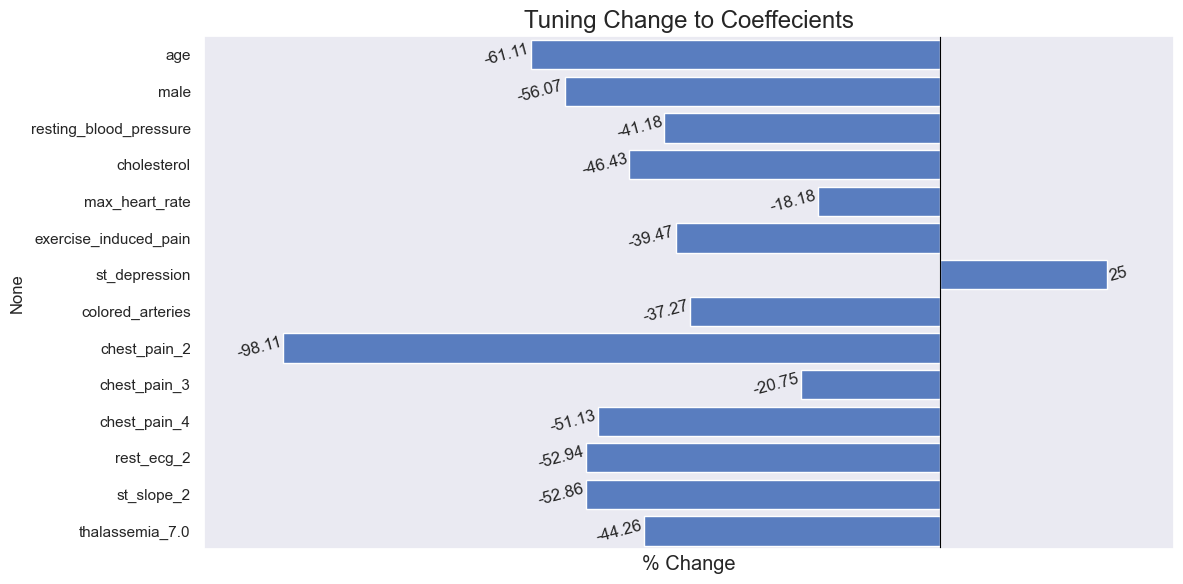

In [23]:
# Initialize matplotlib figure
fig1, ax1 = plt.subplots(figsize= (12,6))

# Plot changes to coefficients
sns.barplot(x= coef_df["delta"], y= coef_df.index, color= "b", ax= ax1)

# Improve legibility
ax1.set_title("Tuning Change to Coeffecients", fontsize= "x-large")
ax1.set_yticklabels(coef_df.index)
ax1.set_xlabel(xlabel= "% Change", fontsize= "large")
ax1.set_xlim(-110,35)
ax1.tick_params(labelbottom= False)
ax1.grid(False)
ax1.axvline(x=0, color="black", linewidth=0.8)
for i in ax1.containers:
    ax1.bar_label(i,rotation=15)
    
plt.tight_layout()
plt.show()

In the plot above, we can see that tuning has decreased the effect sizes of all but one coefficient, meaning the model is less likely to be overfitted to the training data. 

`st_depression` was the only coefficient that increased, at 25%. This makes sense as we saw earlier that it can indicate potentially [life threatening disease](https://www.medicalnewstoday.com/articles/st-depression-on-ecg#:~:text=An%20ECG%20is%20a%20test,reviewed%20on%20April%2025%2C%202024).

`chest_pain_2` (presence of [atypical chest pain](https://my.clevelandclinic.org/health/symptoms/24935-atypical-chest-pain)) decreased the most at -98%. This makes sense since atypical chest pain is not as likely to be associated with heart disease as the other types of chest pain. 

Next, let's investigate how each coefficient affects the odds of having heart disease. 

In [24]:
# Translate log odds of coefficients into legible number
from math import e
tuned_coef["odds change"] = round((e**tuned_coef["tuned"] - 1) * 100,0)
tuned_coef["absolute odds"] = abs(tuned_coef["odds change"])

# Sort coefficients by most to least impactful 
tuned_coef = tuned_coef.sort_values(by= "absolute odds", axis= 0, ascending= False)

# Map coefficient types for clearer visualization
tuned_coef = tuned_coef.reset_index().rename(columns={"index": "coefficient name"})
tuned_coef["coefficient type"] = tuned_coef["coefficient name"].apply(lambda x: "Binary" if x in cat_feats else "Scalar")

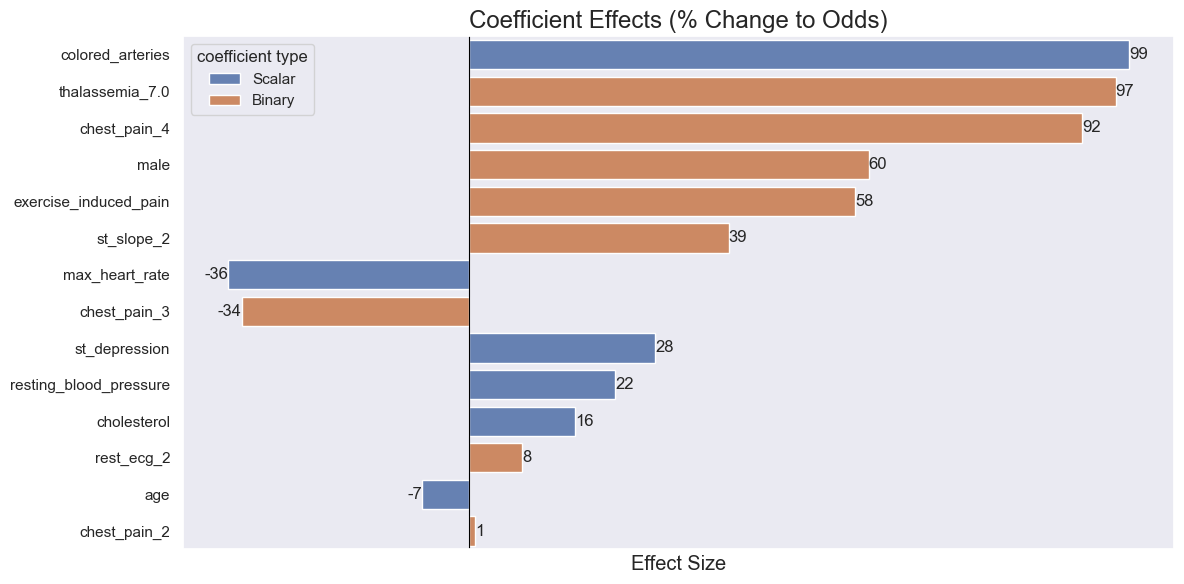

In [25]:
# Initialize matplotlib figure
fig2, ax2 = plt.subplots(figsize= (12,6))

# Plot effects of coefficients on presence of heart disease
sns.barplot(data= tuned_coef, x= "odds change", y="coefficient name", 
            hue="coefficient type", dodge=False, palette=["#597dbf", "#dd8452"], ax= ax2)

# Improve legibility
ax2.set_title("Coefficient Effects (% Change to Odds)", fontsize= "x-large")
ax2.set_xlabel("Effect Size", fontsize= "large")
ax2.set_ylabel("")
ax2.tick_params(labelbottom= False)
ax2.axvline(x=0, color="black", linewidth=0.8)
ax2.grid(False)
for i in ax2.containers:
    ax2.bar_label(i)


plt.tight_layout()
plt.show()

The bar plot above shows how a coefficient affects the odds of having heart disease, with the most impactful at the top and least impactful on the bottom. 

For scalar values (blue), the coefficient is measured in SD (standard deviation) because the data was standard scaled. For example, one SD increase in `colored_arteries` increases the odds of having heart disease by 99%. 

For binary values (orange), the coefficient is either present or not. For example, the presence of `chest_pain_3` decreases the odds of having heart disease by 34%. 

Next, let's investigate how test scores improved from the untuned vs tuned models.

In [26]:
perform_logistic_regression(tuned_log, X_test, y_test, train= False)

76 records analyzed


             Model Scores             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                    ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy                  │ 91.0   │
│ Sensitivity               │ 86.0   │
│ Specificity               │ 95.0   │
│ Positive Predictive Value │ 94.0   │
│ Negative Predictive Value │ 89.0   │
│ False Positive Rate       │ 5.0    │
│ False Negative Rate       │ 14.0   │
└───────────────────────────┴────────┘

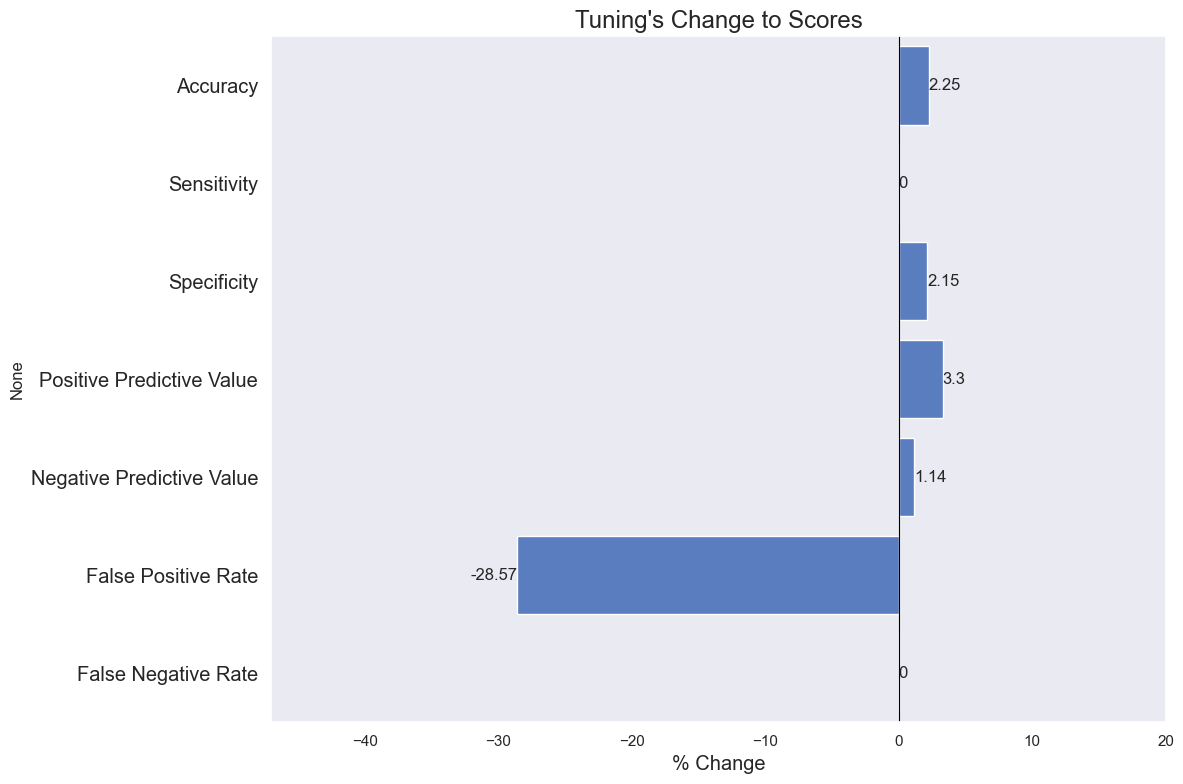

In [27]:
# Create a df of scores to show change with tuning
scores_df = pd.DataFrame(data= {"untuned": [89, 86, 93, 91, 88, 7, 14], "tuned": [91, 86, 95, 94, 89, 5, 14]},
                         index=["Accuracy", "Sensitivity", "Specificity", "Positive Predictive Value", "Negative Predictive Value", "False Positive Rate", "False Negative Rate"] )
scores_df["delta"] = round((scores_df["tuned"] - scores_df["untuned"])/scores_df["untuned"]*100,2)

# Initialize matplotlib figure
fig3, ax3 = plt.subplots(figsize= (12,8))

# Plot data
sns.barplot(x= scores_df["delta"], y= scores_df.index, color= "b", ax= ax3)

# Adjust graph for legibility
ax3.set_title("Tuning's Change to Scores", fontsize= "x-large")
ax3.set_yticklabels(scores_df.index, fontsize= "large")
ax3.set_xlabel(xlabel= "% Change", fontsize= "large")
ax3.set_xlim(-47,20)
ax3.axvline(x=0, color="black", linewidth=0.8)
ax3.grid(False)
for i in ax3.containers:
    ax3.bar_label(i,)
plt.tight_layout()
plt.show()

Tuning the model improved 5/7 of the scores. The biggest improvement was a nearly 30% decrease in the false positive rate. That means 30% less cases where someone is unnecessarily scared at the hospital when getting tested with this model. The other scores increased only slightly, but in a matter as serious as heart disease, that means more lives saved. 

## Conclusion <a name= "conclusion"></a>
[Back to table of contents](#toc)

#### Relationships
There were some surprises in the relationship found with this data. For example, this model showed an increase in age to result in a decreased odds of having heart disease. I would expect the opposite, as medical problems tend to increase with age. Another surprise was asymptomatic angina (`chest_pain_4`) having a 92% increase in the odds of having heart disease. It's possible that asymptomatic angina does not mean the pure absence of heart pain, or maybe most people when being diagnosed with heart disease for the first time do not have chest pain. 

#### Scores
The model correctly predicted 91% of all instances. While We can be confident when using this to screen patients for heart disease. 

The model was better at identifying non-case than case values (95% vs 86%), which could be due to the dataset being biased towards non-case values (164 non-case vs 139 case).

Despite the class imbalance in the dataset, the model was more accurate when predicting case (94%) vs non-case (89%) values.

Looking at the [Baseline Model Performance](https://archive.ics.uci.edu/dataset/45/heart+disease), we see that this model performs above the average baseline performance for logistic regression models (91% vs 82%). When comparing precision (positive predictive value), this model also performs above the average baseline performance for logistic regression models (94% vs 83%). 

Overall, this model has strong accuracy and seems acceptable for use in a clinical setting. Should there be other signs at odds with the results of this model, further tests are warranted to ensure an approrpriate diagnosis. However, this model could save lots of time, money, and lives. 